# `SkyGaussianElongated` tests

The aim of this notebook is to verify the sane behavior of the `SkyGaussianElongated` model. Namely, we check:

- the figure produced in the example docstring;
- the consistency with `astropy.modeling.functional_models.Gaussian2D`;
- the consistency between a `SkyGaussianElongated` with e=0 and a (radially symmetric) `SkyGaussian`;
- the error we introduce by normalizing the elongated Gaussian on the plane.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import Angle
from astropy.modeling.functional_models import Gaussian2D
from gammapy.image.models.core import SkyGaussian, SkyGaussianElongated
from gammapy.maps import Map, WcsGeom

## Check the figure produced in the example docstring

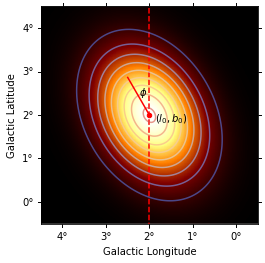

In [3]:
m_geom = WcsGeom.create(binsz=0.01, width=(5, 5), skydir=(2, 2), coordsys="GAL", proj="AIT")
phi = Angle("30 deg")
model = SkyGaussianElongated("2 deg", "2 deg", "1 deg", 0.7, phi, frame='galactic')


coords = m_geom.get_coord()
lon = coords.lon * u.deg
lat = coords.lat * u.deg
vals = model(lon, lat)
skymap = Map.from_geom(m_geom, data=vals.value)

_, ax, _ = skymap.smooth("0.05 deg").plot()

transform = ax.get_transform('galactic')
ax.scatter(2, 2, transform=transform, s=20, edgecolor='red', facecolor='red')
ax.text(1.5, 1.85, r"$(l_0, b_0)$", transform=transform, ha="center")
ax.plot([2, 2 + np.sin(phi)], [2, 2 + np.cos(phi)], color="r", transform=transform)
ax.vlines(x=2, color='r', linestyle='--', transform=transform, ymin=-5, ymax=5)
ax.text(2.25, 2.45, r"$\phi$", transform=transform);

ax.contour(skymap.data, cmap='coolwarm', levels=10, alpha=0.6);

## Check the consistency with `astropy.modeling.functional_models.Gaussian2D`

In [4]:
# Define a SkyGaussianElongated
major_axis = 2 * u.deg
minor_axis = 1 * u.deg
e = np.sqrt(1-(minor_axis/major_axis)**2)
phi = Angle(50, 'deg')
model_gammapy = SkyGaussianElongated("5 deg", "5 deg", major_axis, e, phi, frame='galactic')

# Define an equivalent Gaussian2D
norm = 1 / (2 * np.pi * major_axis * minor_axis)
norm = norm.to('sr-1').value
phi = -phi.radian
model_astropy = Gaussian2D(amplitude=norm, x_mean=5, y_mean=5, x_stddev=1, y_stddev=2, theta=phi)

Compare the model profiles along the lat = 8 deg parallel:

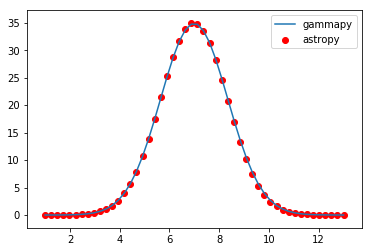

In [5]:
lon = np.linspace(1, 13) * u.deg
lat = 8 * u.deg
for l, b in zip(lon, [lat]):
    vals_gammapy = model_gammapy(lon, lat)
    vals_astropy = model_astropy(lon.value, lat.value)

plt.plot(lon.value, vals_gammapy.value, label='gammapy')
plt.scatter(lon.value, vals_astropy, label='astropy', color='red')

plt.legend();

Compare visually the two models:

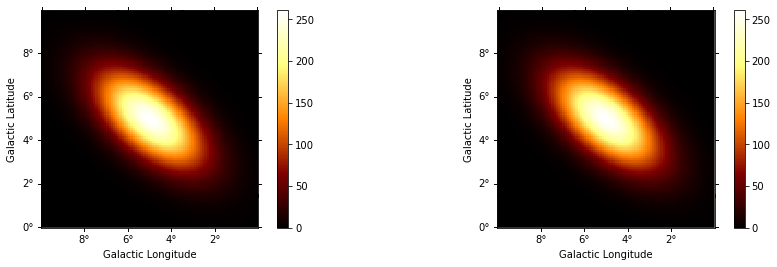

In [6]:
geom = WcsGeom.create(binsz=0.1, width=(10, 10), skydir=(5, 5), coordsys="GAL", proj="AIT")
coords = geom.get_coord()
lon = u.Quantity(coords.lon, 'deg', copy=False)
lat = u.Quantity(coords.lat, 'deg', copy=False)

vals_astropy = model_astropy(lon.value, lat.value)
vals_gammapy = model_gammapy(lon, lat)

skymap_astropy = Map.from_geom(geom, data=vals_astropy)
skymap_gammapy = Map.from_geom(geom, data=vals_gammapy.value)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4), subplot_kw={'projection': geom.wcs})

skymap_astropy.smooth("0.05 deg").plot(ax=axes[0], add_cbar=True)
skymap_gammapy.smooth("0.05 deg").plot(ax=axes[1], add_cbar=True)

plt.show()

## Comparison between a SkyGaussianElongated with e=0 and a SkyGaussian

Here is a qualitative comparison between a SkyGaussian (left), i.e. a radially symmetric Gaussian, and a SkyGaussianElongated with e=0 (right):

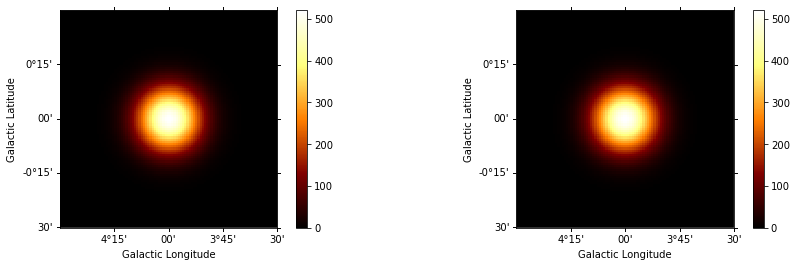

In [7]:
model_elongated = SkyGaussianElongated("5 deg", "5 deg", "1 deg", 0.0, "40 deg", frame='galactic')
model_symmetric = SkyGaussian("5 deg", "5 deg", "1 deg", frame='galactic')

vals_elongated = model_elongated(lon, lat)
vals_symmetric = model_symmetric(lon, lat)

skymap_elongated = Map.from_geom(geom, data=vals_elongated.value)
skymap_symmetric = Map.from_geom(geom, data=vals_symmetric.value)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4), subplot_kw={'projection': m_geom.wcs})

skymap_symmetric.smooth("0.05 deg").plot(ax=axes[0], add_cbar=True)
skymap_elongated.smooth("0.05 deg").plot(ax=axes[1], add_cbar=True)

plt.show()

The elongated Gaussian is defined on the sphere, but normalized on the plane. The symmetric Gaussian, on the other hand, is defined and normalized on the sphere. I investigate how the difference between these description varies as a funtion of the Gaussian sigma.

First, let's compare the normalization factors using the analytical formulas for the two models: 

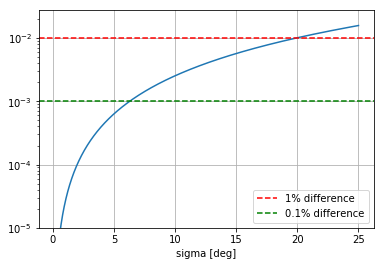

In [8]:
sigmas = np.linspace(0.1, 25, 1000) * u.deg
norms_symmetric = []
norms_elongated = []

for sigma in sigmas:
    a = 1.0 - np.cos(sigma.to('rad') )
    norm_symmetric = 1 / (4 * np.pi * a * (1.0 - np.exp(-1.0 / a))) / u.sr
    norms_symmetric.append(norm_symmetric.value)
    
    norm_elongated = 1 / (2 * np.pi * sigma * sigma)
    norms_elongated.append(norm_elongated.to('sr-1').value)
    
diff = (np.asarray(norms_symmetric) - np.asarray(norms_elongated)) / np.asarray(norms_symmetric)
plt.plot(sigmas.value, diff)
plt.yscale('log')
plt.ylim(1e-5)
plt.axhline(0.01, 0, 20, color='red', ls='dashed', label='1% difference')
plt.axhline(0.001, 0, 20, color='green', ls='dashed', label='0.1% difference')

plt.xlabel('sigma [deg]')
plt.grid()
plt.legend();

the difference is 0.1% for sigma ~6 deg, and 1% for sigma ~ 20 deg.

Let's now integrate the two models on a sky map and compare the results (ideally, these should be consistent what shown above):

In [15]:
m_geom = WcsGeom.create(binsz=0.1, width=(125, 125), skydir=(0, 0), coordsys="GAL", proj="AIT")
coords = m_geom.get_coord()
angles = m_geom.solid_angle()
lon = u.Quantity(coords.lon, 'deg', copy=False)
lat = u.Quantity(coords.lat, 'deg', copy=False)

sigmas = np.linspace(4, 25, 10) * u.deg
int_symmetric = []
int_elongated = []

for sigma in sigmas:
    model_elongated = SkyGaussianElongated("0 deg", "0 deg", sigma, 0.0, "20 deg", frame='galactic')
    model_symmetric = SkyGaussian("0 deg", "0 deg", sigma, frame='galactic')

    vals_elongated = model_elongated(lon, lat)
    vals_symmetric = model_symmetric(lon, lat)
    
    int_symmetric.append(np.sum(vals_symmetric * angles))
    int_elongated.append(np.sum(vals_elongated * angles))

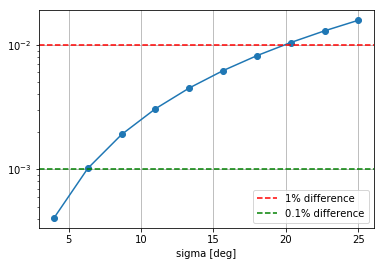

In [16]:
int_diff = (np.asarray(int_symmetric) - np.asarray(int_elongated)) / np.asarray(int_symmetric)
plt.plot(sigmas.value, int_diff, '-o')
plt.yscale('log')
plt.axhline(0.01, 0, 20, color='red', ls='dashed', label='1% difference')
plt.axhline(0.001, 0, 4, color='green', ls='dashed', label='0.1% difference')

plt.xlabel('sigma [deg]')
plt.grid()
plt.legend();

This confirms that the difference between the two normalizations is less then 0.1%, for gaussians with sigma<6 deg. 